# Transformer Architecture

You understand attention. You understand self-attention.

Now let's build the complete architecture that changed everything.

The paper was called "Attention is All You Need". They meant it. No RNNs, no convolutions. Just attention, layer norms, and feed-forward networks.

## The Big Picture

A Transformer has two main parts:

**Encoder:** Processes the input sequence  
**Decoder:** Generates the output sequence

Both use self-attention, but differently:
- Encoder: Bidirectional (each token sees all tokens)
- Decoder: Masked (each token only sees past tokens)
- Decoder also has cross-attention to encoder outputs

```
Input → Encoder → Encoder Output
                       ↓
Output ← Decoder ← Cross-Attention
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Building Blocks

Before assembling the full architecture, we need these components:

1. **Multi-head self-attention** (already covered)
2. **Position-wise feed-forward network**
3. **Layer normalization**
4. **Residual connections**
5. **Positional encoding**

Let's build each one.

### 1. Multi-Head Attention (Review)

In [2]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Projection matrices
        self.W_Q = np.random.randn(d_model, d_model) * 0.01
        self.W_K = np.random.randn(d_model, d_model) * 0.01
        self.W_V = np.random.randn(d_model, d_model) * 0.01
        self.W_O = np.random.randn(d_model, d_model) * 0.01
    
    def split_heads(self, x):
        """Split into multiple heads: (seq_len, d_model) → (num_heads, seq_len, d_k)"""
        seq_len = x.shape[0]
        x = x.reshape(seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 0, 2)
    
    def forward(self, Q, K, V, mask=None):
        """
        Args:
            Q, K, V: (seq_len, d_model)
            mask: (seq_len, seq_len) optional
        """
        # Project
        Q = Q @ self.W_Q
        K = K @ self.W_K
        V = V @ self.W_V
        
        # Split heads
        Q = self.split_heads(Q)  # (num_heads, seq_len, d_k)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Scaled dot-product attention for each head
        scores = (Q @ K.transpose(0, 2, 1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores + mask
        
        attn_weights = softmax(scores)
        attn_output = attn_weights @ V  # (num_heads, seq_len, d_k)
        
        # Concatenate heads
        attn_output = attn_output.transpose(1, 0, 2)  # (seq_len, num_heads, d_k)
        attn_output = attn_output.reshape(attn_output.shape[0], self.d_model)
        
        # Final projection
        output = attn_output @ self.W_O
        
        return output

### 2. Position-wise Feed-Forward Network

After attention, each position goes through a simple 2-layer neural network. INDEPENDENTLY.

**Architecture:**
```
FFN(x) = ReLU(x·W₁ + b₁)·W₂ + b₂
```

Typically: d_model → d_ff (2048-4096) → d_model

**Why?** Attention is linear operations. FFN adds non-linearity and feature transformation.

In [3]:
class FeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff) * 0.01
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * 0.01
        self.b2 = np.zeros(d_model)
    
    def forward(self, x):
        """
        Args:
            x: (seq_len, d_model)
        Returns:
            output: (seq_len, d_model)
        """
        hidden = np.maximum(0, x @ self.W1 + self.b1)  # ReLU
        output = hidden @ self.W2 + self.b2
        return output

The "position-wise" means each position is processed independently. Token 1's FFN doesn't interact with token 2's FFN.

### 3. Layer Normalization

Normalizes across features (not batch). For each position, compute mean and std across the d_model dimensions.

**Formula:**
```
LayerNorm(x) = γ · (x - μ) / σ + β
```

Where μ and σ are computed per position across features.

**Why?** Stabilizes training, allows deeper networks.

In [4]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-6):
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)
        self.eps = eps
    
    def forward(self, x):
        """
        Args:
            x: (seq_len, d_model)
        """
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.std(x, axis=-1, keepdims=True)
        normalized = (x - mean) / (std + self.eps)
        return self.gamma * normalized + self.beta

### 4. Residual Connections

Each sub-layer (attention, FFN) uses a residual connection:

```
output = LayerNorm(x + Sublayer(x))
```

The original input x is added to the sublayer output. This allows gradients to flow directly through the network.

**Why?** Without residuals, deep networks struggle to train. Residuals create shortcuts.

### 5. Positional Encoding

Attention has no notion of order. "cat sat" and "sat cat" look identical to self-attention.

**Solution:** Add positional information to embeddings.

**Original Transformer uses sinusoidal encoding:**
```
PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

Each position gets a unique vector. Different frequencies for different dimensions.

In [5]:
def positional_encoding(seq_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Returns:
        pe: (seq_len, d_model)
    """
    pe = np.zeros((seq_len, d_model))
    position = np.arange(0, seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

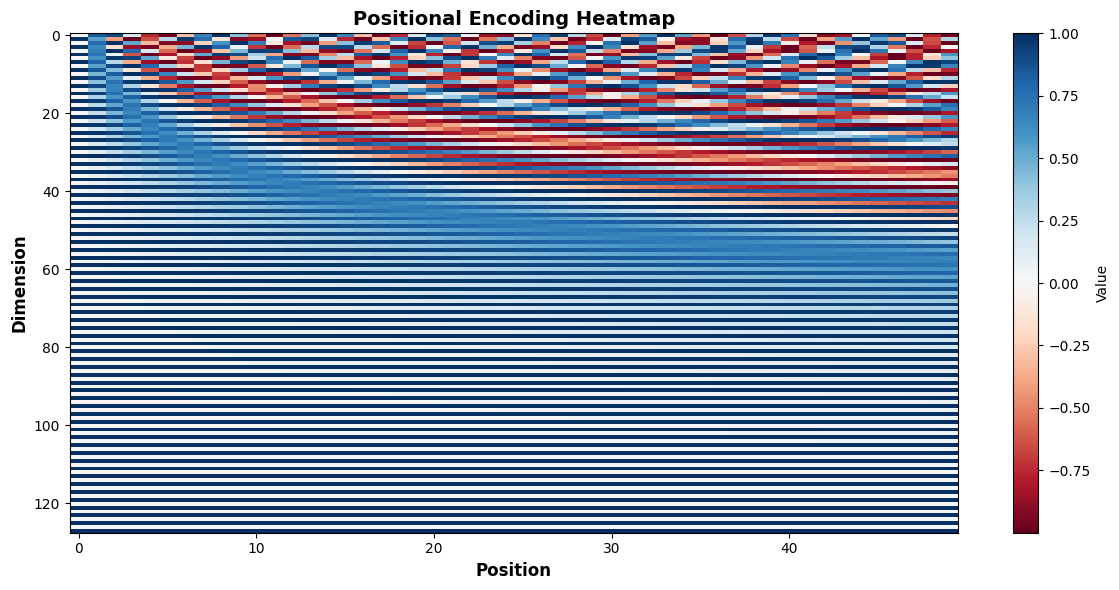

Shape: (50, 128)

Each position has a unique pattern of sine/cosine values


In [6]:
# Visualize positional encodings
pe = positional_encoding(seq_len=50, d_model=128)

plt.figure(figsize=(12, 6))
plt.imshow(pe.T, cmap='RdBu', aspect='auto', interpolation='nearest')
plt.xlabel('Position', fontsize=12, fontweight='bold')
plt.ylabel('Dimension', fontsize=12, fontweight='bold')
plt.title('Positional Encoding Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

print(f"Shape: {pe.shape}")
print("\nEach position has a unique pattern of sine/cosine values")

Notice the wave patterns. Lower dimensions oscillate slowly, higher dimensions rapidly. This gives the model rich positional information.

## Encoder Layer

One encoder layer has:
1. Multi-head self-attention
2. Add & Norm (residual + layer norm)
3. Feed-forward network
4. Add & Norm again

```
x → Self-Attention → Add & Norm → FFN → Add & Norm → output
     ↑______________|              ↑______________|  
         residual                      residual
```

In [7]:
class EncoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
    
    def forward(self, x):
        """
        Args:
            x: (seq_len, d_model)
        """
        # Self-attention with residual
        attn_output = self.self_attn.forward(x, x, x)
        x = self.norm1.forward(x + attn_output)
        
        # Feed-forward with residual
        ff_output = self.feed_forward.forward(x)
        x = self.norm2.forward(x + ff_output)
        
        return x

The full encoder stacks N of these layers (typically N=6).

In [8]:
class Encoder:
    def __init__(self, num_layers, d_model, num_heads, d_ff):
        self.layers = [EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)]
        self.norm = LayerNorm(d_model)
    
    def forward(self, x):
        """
        Args:
            x: (seq_len, d_model) - embeddings + positional encoding
        """
        for layer in self.layers:
            x = layer.forward(x)
        return self.norm.forward(x)

## Decoder Layer

Decoder layer is similar but has THREE sub-layers:
1. Masked self-attention (can't see future)
2. Cross-attention to encoder output
3. Feed-forward network

Each with Add & Norm.

```
x → Masked Self-Attention → Add & Norm
         ↑___________________|  
                                ↓
    Encoder Output → Cross-Attention → Add & Norm
                          ↑______________|  
                                         ↓
                         FFN → Add & Norm → output
                          ↑______________|  
```

In [9]:
class DecoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.masked_self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
    
    def forward(self, x, encoder_output, mask):
        """
        Args:
            x: (seq_len, d_model) - decoder input
            encoder_output: (src_len, d_model)
            mask: (seq_len, seq_len) - causal mask
        """
        # Masked self-attention
        attn_output = self.masked_self_attn.forward(x, x, x, mask=mask)
        x = self.norm1.forward(x + attn_output)
        
        # Cross-attention (Q from decoder, K/V from encoder)
        cross_output = self.cross_attn.forward(x, encoder_output, encoder_output)
        x = self.norm2.forward(x + cross_output)
        
        # Feed-forward
        ff_output = self.feed_forward.forward(x)
        x = self.norm3.forward(x + ff_output)
        
        return x

In [10]:
class Decoder:
    def __init__(self, num_layers, d_model, num_heads, d_ff):
        self.layers = [DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)]
        self.norm = LayerNorm(d_model)
    
    def forward(self, x, encoder_output, mask):
        for layer in self.layers:
            x = layer.forward(x, encoder_output, mask)
        return self.norm.forward(x)

## Complete Transformer

Now we combine everything:

In [11]:
class Transformer:
    def __init__(self, num_layers=6, d_model=512, num_heads=8, d_ff=2048, 
                 src_vocab_size=10000, tgt_vocab_size=10000, max_seq_len=100):
        self.d_model = d_model
        
        # Embeddings
        self.src_embedding = np.random.randn(src_vocab_size, d_model) * 0.01
        self.tgt_embedding = np.random.randn(tgt_vocab_size, d_model) * 0.01
        
        # Positional encoding (precomputed)
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        
        # Encoder and decoder
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff)
        
        # Output projection
        self.output_proj = np.random.randn(d_model, tgt_vocab_size) * 0.01
    
    def create_causal_mask(self, size):
        """Upper triangle mask for decoder self-attention"""
        mask = np.triu(np.ones((size, size)) * -1e9, k=1)
        return mask
    
    def encode(self, src_tokens):
        """
        Args:
            src_tokens: (seq_len,) array of token indices
        """
        seq_len = len(src_tokens)
        
        # Embed + positional encoding
        x = self.src_embedding[src_tokens] + self.pos_encoding[:seq_len]
        
        # Encode
        encoder_output = self.encoder.forward(x)
        return encoder_output
    
    def decode(self, tgt_tokens, encoder_output):
        """
        Args:
            tgt_tokens: (seq_len,) array of token indices
            encoder_output: (src_len, d_model)
        """
        seq_len = len(tgt_tokens)
        
        # Embed + positional encoding
        x = self.tgt_embedding[tgt_tokens] + self.pos_encoding[:seq_len]
        
        # Create causal mask
        mask = self.create_causal_mask(seq_len)
        
        # Decode
        decoder_output = self.decoder.forward(x, encoder_output, mask)
        
        # Project to vocabulary
        logits = decoder_output @ self.output_proj
        
        return logits
    
    def forward(self, src_tokens, tgt_tokens):
        """Full forward pass"""
        encoder_output = self.encode(src_tokens)
        logits = self.decode(tgt_tokens, encoder_output)
        return logits

## Testing the Transformer

In [12]:
# Create a small transformer
model = Transformer(
    num_layers=2,
    d_model=64,
    num_heads=4,
    d_ff=128,
    src_vocab_size=100,
    tgt_vocab_size=100,
    max_seq_len=50
)

# Example: translate [5, 12, 23, 8] to [45, 67, 12]
src_tokens = np.array([5, 12, 23, 8])
tgt_tokens = np.array([45, 67, 12])

# Encode
encoder_output = model.encode(src_tokens)
print(f"Encoder output shape: {encoder_output.shape}")
print(f"Expected: ({len(src_tokens)}, {model.d_model})")

# Decode
logits = model.decode(tgt_tokens, encoder_output)
print(f"\nDecoder logits shape: {logits.shape}")
print(f"Expected: ({len(tgt_tokens)}, vocab_size)")

# Full forward
output = model.forward(src_tokens, tgt_tokens)
print(f"\nFull forward output shape: {output.shape}")

Encoder output shape: (4, 64)
Expected: (4, 64)

Decoder logits shape: (3, 100)
Expected: (3, vocab_size)

Full forward output shape: (3, 100)


## What Each Component Does

**Encoder:**
- Reads the entire input at once (bidirectional)
- Each token attends to ALL input tokens
- Produces contextualized representations

**Decoder:**
- Generates output token by token (autoregressive)
- Masked self-attention: only sees previous outputs
- Cross-attention: queries encoder for relevant input context

**Multi-head attention:**
- Multiple attention patterns in parallel
- Different heads learn different relationships

**Feed-forward:**
- Non-linear transformation
- Applied independently to each position
- Adds representational capacity

**Residuals + LayerNorm:**
- Enable training deep networks
- Stabilize gradients
- Allow information to flow directly through layers

## Training Process (Conceptual)

During training:

1. Feed source sentence to encoder
2. Feed target sentence to decoder (shifted right)
3. Decoder predicts next token at each position
4. Compute loss (cross-entropy) against true tokens
5. Backprop, update weights

**Teacher forcing:** During training, decoder sees the TRUE previous tokens, not its own predictions.

Example:
```
Source: "I love cats"
Target: "J'adore les chats"

Decoder input:  [START, J', adore, les]
Decoder output: [J', adore, les, chats]

Each position predicts the next token.
```

## Inference: Greedy Decoding

At inference, we don't have the target. Generate token by token:

In [13]:
def greedy_decode(model, src_tokens, start_token, max_len=20):
    """
    Generate output autoregressively.
    """
    # Encode source once
    encoder_output = model.encode(src_tokens)
    
    # Start with start token
    tgt_tokens = [start_token]
    
    for _ in range(max_len):
        # Decode with current tokens
        logits = model.decode(np.array(tgt_tokens), encoder_output)
        
        # Get last token's prediction
        next_token_logits = logits[-1]
        next_token = np.argmax(next_token_logits)
        
        tgt_tokens.append(next_token)
        
        # Stop if we generate end token (assume 1)
        if next_token == 1:
            break
    
    return np.array(tgt_tokens)

In [14]:
# Demo greedy decoding
src = np.array([5, 12, 23, 8])
start_token = 0

generated = greedy_decode(model, src, start_token, max_len=10)
print(f"Generated tokens: {generated}")
print(f"Length: {len(generated)}")

Generated tokens: [ 0 28 58 58 60 60 60 60 60 73 60]
Length: 11


Each step:
1. Pass current sequence to decoder
2. Get logits for next token
3. Pick highest probability token (greedy)
4. Append to sequence
5. Repeat

More sophisticated: beam search, nucleus sampling, etc.

## Encoder-Only vs Decoder-Only

The architecture we built is encoder-decoder (like the original Transformer).

Modern models often use variants:

**Encoder-only (BERT):**
- Only encoder stack
- Bidirectional attention everywhere
- Good for understanding tasks (classification, NER, QA)
- Can't generate text

**Decoder-only (GPT):**
- Only decoder stack (without cross-attention)
- Causal/masked attention only
- Good for generation tasks
- Can do everything by framing as text generation

**Encoder-decoder (T5, BART):**
- Both stacks
- Best for translation, summarization
- More parameters but versatile

## Parameter Count

Let's count parameters in a typical configuration:

**Base model (d_model=512, num_heads=8, d_ff=2048, 6 layers):**

In [15]:
def count_parameters(d_model, num_heads, d_ff, num_layers, vocab_size):
    # Embeddings
    embedding_params = vocab_size * d_model * 2  # src + tgt
    
    # Multi-head attention (per layer)
    # W_Q, W_K, W_V, W_O
    attn_params = 4 * d_model * d_model
    
    # Feed-forward (per layer)
    ff_params = d_model * d_ff + d_ff + d_ff * d_model + d_model
    
    # Layer norm (per layer, 2 instances)
    ln_params = 2 * 2 * d_model
    
    # Per encoder layer
    encoder_layer = attn_params + ff_params + ln_params
    
    # Per decoder layer (2 attention + ffn + 3 layer norms)
    decoder_layer = 2 * attn_params + ff_params + 3 * 2 * d_model
    
    # Total
    total = embedding_params + num_layers * (encoder_layer + decoder_layer)
    total += d_model * vocab_size  # Output projection
    
    return total

params = count_parameters(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_layers=6,
    vocab_size=30000
)

print(f"Total parameters: {params:,}")
print(f"Approximately: {params / 1e6:.1f}M parameters")

Total parameters: 90,181,632
Approximately: 90.2M parameters


Most parameters are in embeddings and feed-forward layers, not attention.

## Key Takeaways

**The Transformer:**
- Encoder processes input (bidirectional attention)
- Decoder generates output (masked attention + cross-attention)
- No recurrence, no convolutions - just attention and feed-forward

**Core components:**
- Multi-head attention (Q, K, V projections, multiple heads)
- Position-wise feed-forward (2-layer MLP per position)
- Layer normalization (stabilizes training)
- Residual connections (enables deep networks)
- Positional encoding (gives order information)

**Why it works:**
- Attention sees all positions at once (no sequential bottleneck)
- Multiple heads learn diverse patterns
- Residuals enable gradient flow
- Can be fully parallelized (unlike RNNs)

**The magic formula:**
```
Attention(Q, K, V) = softmax(Q·K^T / √d_k) · V
```

Everything else is just scaffolding around this core operation.

Next: Pre-training objectives (how models like BERT and GPT learn).